#**Galaxy Zoo**

###*A Multi-Regression model for classification of Morphology of Galaxies.*


This model came **very close to the Second Position** holder of the **Kaggle Competition Galaxy Zoo** with a 

Private Score - **0.07788**

Public Score - **0.07794**

This model is based on a Kaggle Dataset [Galaxy Zoo] which seeks to answer 11 questions about the morphology of a Galaxy, given only a RGB image of the galaxy. These questions have different number of responses to quantify the answer. The questions are as follows:


Q1. Is the object a smooth galaxy, a galaxy with features/disk or a star? 3 responses

Q2. Is it edge-on? 2 responses

Q3. Is there a bar? 2 responses

Q4. Is there a spiral pattern? 2 responses

Q5. How prominent is the central bulge? 4 responses

Q6. Is there anything "odd" about the galaxy? 2 responses

Q7. How round is the smooth galaxy? 3 responses

Q8. What is the odd feature? 7 responses

Q9. What shape is the bulge in the edge-on galaxy? 3 responses

Q10. How tightly wound are the spiral arms? 3 responses

Q11. How many spiral arms are there? 6 responses


####**Example**
Here is a simplified example: a galaxy had 80% of users identify it as smooth, 15% as having features/disk, and 5% as a star/artifact.

Class1.1 = 0.80

Class1.2 = 0.15

Class1.3 = 0.05

For the 80% of users that identified the galaxy as "smooth", they also recorded responses for the galaxy's relative roundness. These votes were for 50% completely round, 25% in-between, and 25% cigar-shaped. The values in the solution file are thus:

Class 7.1 = 0.80 * 0.50 = 0.40

Class 7.2 = 0.80 * 0.25 = 0.20

Class 7.3 = 0.80 * 0.25 = 0.20

##**But here's the catch!**
This model seeks to answer all 11 questions for these Galaxy images **without the use of any such Decision Tree** purely based on Computer Vision and Deep Learning techniques which I will walk you through as I proceed with my notebook. I have used the **Fastai Library based on a PyTorch Framework** for this model.

##**Let's Get Started**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from torch.nn import *
import pandas as pd

In [0]:
path = Path('/home/ubuntu/Kharbanda/Galaxy')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/ubuntu/Kharbanda/Galaxy')

First you need to download the dataset from Kaggle. The downloaded dataset will be a zipped file which can be unzipped by uncommenting and running the following commands.

In [0]:
# ! kaggle competitions download -c galaxy-zoo-the-galaxy-challenge -p {path}
# ! unzip -q -n {path}/galaxy-zoo-the-galaxy-challenge.zip -d {path}

In [0]:
# ! unzip -q -n {path}/training_solutions_rev1.zip -d {path}
# ! unzip -q -n {path}/images_training_rev1.zip -d {path}

In [0]:
path.ls()

[PosixPath('/home/ubuntu/Kharbanda/Galaxy/images_training'),
 PosixPath('/home/ubuntu/Kharbanda/Galaxy/Submissions'),
 PosixPath('/home/ubuntu/Kharbanda/Galaxy/test'),
 PosixPath('/home/ubuntu/Kharbanda/Galaxy/labels.csv'),
 PosixPath('/home/ubuntu/Kharbanda/Galaxy/.ipynb_checkpoints')]

Let's have a look at the csv file to see if our labels are consistant with the information provided above. 

In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


The **label_from_df** funtion used below by default only considers the cols = 1 of the dataframe for labelling. A list of columns has to be given inorder to tell the function that there are more labels and they are available in these columns of the dataframe.

Also, by default it considers it to be a classification problem, hence the labels are assumed to be a list of classes. The label_cls is thus changed to FloatList to create a framework that regresses over these given set of labels. 

In [0]:
col_list = [i for i in range(1,38)]

The **split_by_rand_pct** automatically segregates the dataset into 10% validation and 90% training. We fix a random seed because we don't want our validation set to keep changing everytime we run the model. This way we ensure conlusive results which helps us train the model better.

In [0]:
np.random.seed(42)
src = (ImageList.from_df(df, path/"images_training", suffix='.jpg')
       .split_by_rand_pct(0.10)
       .label_from_df(cols = col_list, label_cls = FloatList))

If we look closely at the decision tree, the orientation of the galaxy in its image doesn't affect any question. Hence we turn on the **flip_vert** parameter which randomly rotates the images by multiples of 90 degrees during Training time but doesn't do so while the validation dataset is being processed, for obvious reasons. 

Also, we start of with the size of the images as 224 x 224 and we will increase this size once we train our model on the smaller size. 

In [0]:
data = (src.transform(get_transforms(flip_vert=True), size=224)
        .databunch(bs=64).normalize())

It is very important to constantly check the dataset once the databunch is ready in order to be familiar with what we are dealing with. This is also done to ensure everything is in place and we can start training next. 

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/data.py:306: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


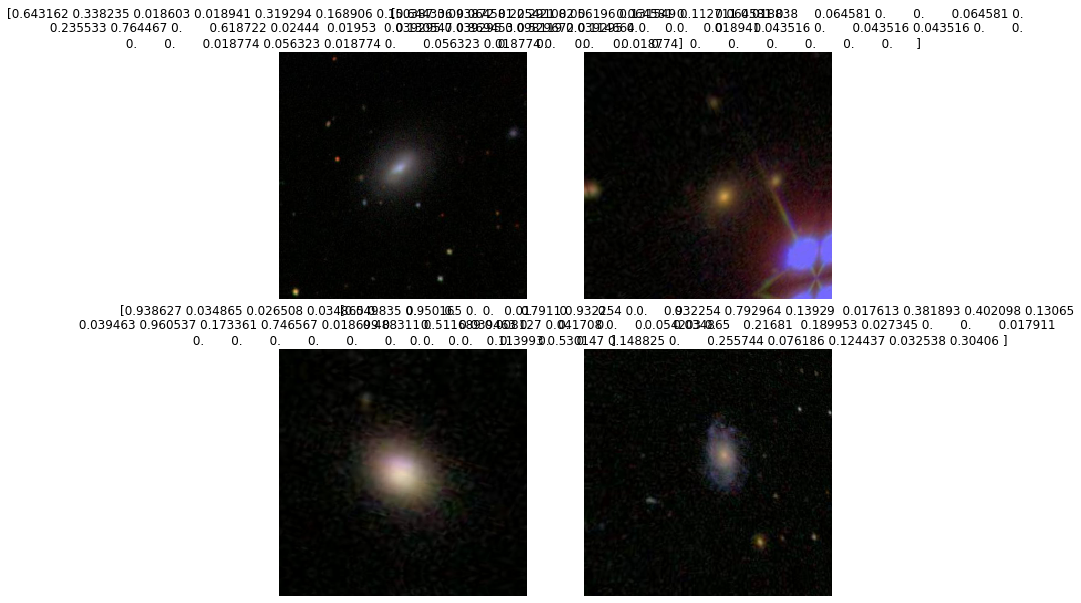

In [0]:
data.show_batch(2, figsize = (10,10))

Here, the model uses a **ResNet34 architechture**, which is pretrained and starts training with ImageNet weights. (Typically **Transfer Learning**) 

Also, the model uses root_mean_squared_error as the metric because the evaluation of the dataset is done based on this for the test set [as per the guidelines of the competiton]. 

Moreover, the loss function I used is BCE Loss. For more details on why I used this loss funtion, read up on [this link.](https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8)

Although, intuitively MSELoss would seem as a better loss function for this model, but loss function graph which we find from lr_find turns out totally flat and model doesn't train well. 

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[root_mean_squared_error])
learn.loss = BCELoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


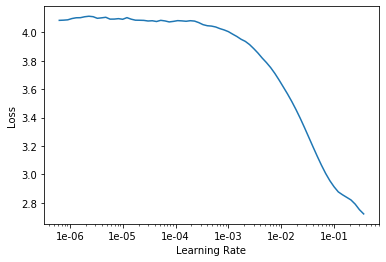

In [0]:
learn.lr_find()
learn.recorder.plot()

To start training, the point with maximum slope on the Loss vs LR graph is chosen, here 1e-2 is used. 

In [0]:
learn.fit_one_cycle(7, slice(1e-2))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.040990,0.029617,0.171973,03:22
1,0.014054,0.011932,0.109111,03:22
2,0.012491,0.011021,0.104848,03:20
3,0.011729,0.010097,0.100378,03:20
4,0.010927,0.009294,0.096277,03:16
5,0.010127,0.009070,0.094939,03:17
6,0.009832,0.008954,0.094443,03:14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


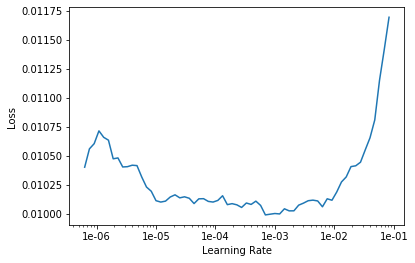

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(5e-5, 1e-3))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.009861,0.008896,0.094149,03:11
1,0.009859,0.008958,0.094475,03:08
2,0.009951,0.008805,0.093691,03:09
3,0.009739,0.008707,0.093174,03:12
4,0.009785,0.008740,0.093344,03:10


In [0]:
learn.save('Galaxy-smol-F')

In [0]:
learn.load('Galaxy-smol-F')

Initially, the back propagation changes only the last few layers of the ResNet as the starting and middle layers are frozen. Now, model is **unfreezed** so that back propagation changes values of all the layers. 

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


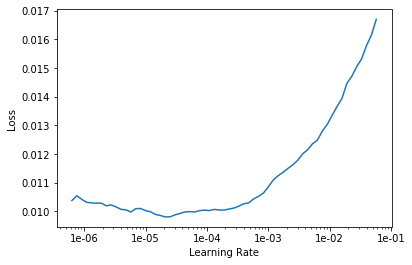

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(7, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.009564,0.008689,0.093085,03:13
1,0.009445,0.008450,0.091791,03:14
2,0.009127,0.008093,0.089833,03:16
3,0.008641,0.007784,0.088107,03:15
4,0.008479,0.007575,0.086915,03:16
5,0.008460,0.007333,0.085514,03:11
6,0.008257,0.007323,0.085454,03:15


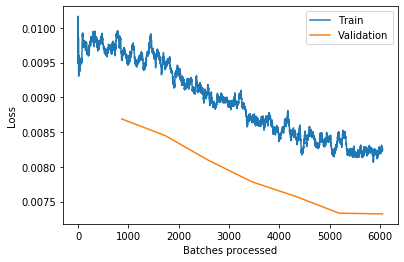

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('Galaxy-smol-UF')

In [0]:
learn.fit_one_cycle(6, slice(1e-6, 5e-5))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.008321,0.007339,0.085551,03:12
1,0.008229,0.007341,0.085569,03:11
2,0.008287,0.007301,0.085330,03:11
3,0.008131,0.007237,0.084960,03:13
4,0.008101,0.007237,0.084953,03:11
5,0.008085,0.007241,0.084975,03:11


In [0]:
learn.save('Galaxy-smol-UF')

##**Going Big**

Since the model is trained enough on a smaller image, I now increase the size of the images. 

In [0]:
data = (src.transform(get_transforms(flip_vert=True), size=400)
        .databunch(bs=64).normalize())

Weight decay of 1e-3 is passed as a parameter to the model. 

In [0]:
wd = 1e-3
learn = cnn_learner(data, models.resnet34, metrics=[root_mean_squared_error], wd=wd)
learn.loss = BCELoss

In [0]:
learn.load('Galaxy-smol-UF')

Learner(data=ImageDataBunch;

Train: LabelList (55421 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: FloatList
[0.383147 0.616853 0.       0.       0.616853 0.038452 0.578401 0.418398 0.198455 0.       0.104752 0.512101 0.
 0.054453 0.945547 0.201463 0.181684 0.       0.       0.027227 0.       0.027227 0.       0.       0.       0.
 0.       0.       0.279952 0.138445 0.       0.       0.092886 0.       0.       0.       0.325512],[0.327001 0.663777 0.009222 0.031178 0.632599 0.46737  0.165229 0.591328 0.041271 0.       0.236781 0.160941 0.234877
 0.189149 0.810851 0.       0.135082 0.191919 0.       0.       0.140353 0.       0.048796 0.       0.       0.012414
 0.       0.018764 0.       0.131378 0.45995  0.       0.591328 0.       0.       0.       0.      ],[0.765717 0.177352 0.056931 0.       0.177352 0.       0.177352 0.       0.177352 0.       0.11779  0.059562 0.
 0.       1.       0.       0.741864 0.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


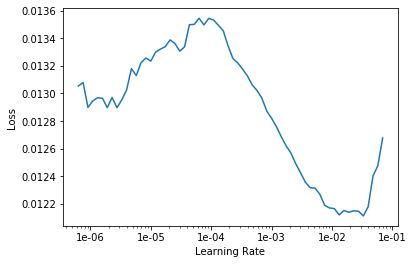

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(7, slice(1e-3))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.009761,0.008626,0.092757,06:01
1,0.008907,0.007782,0.088106,06:02
2,0.008824,0.007635,0.087269,06:04
3,0.008597,0.007469,0.086305,06:04
4,0.008364,0.007384,0.085812,06:04
5,0.008488,0.007334,0.085525,06:03
6,0.008216,0.007342,0.085573,06:01


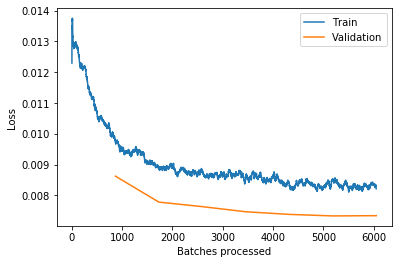

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('Galaxy-big-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


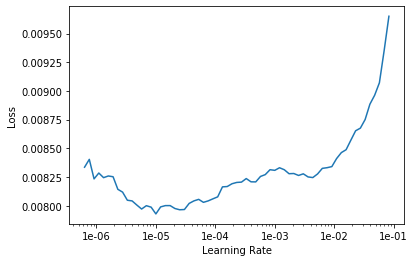

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(6, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.008167,0.007328,0.085487,06:03
1,0.008418,0.007373,0.085754,06:01
2,0.008164,0.007408,0.085955,06:03
3,0.008378,0.007347,0.085596,06:05
4,0.008352,0.007310,0.085380,06:04
5,0.008254,0.007340,0.085556,06:02


In [0]:
learn.save('Galaxy-big-2')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


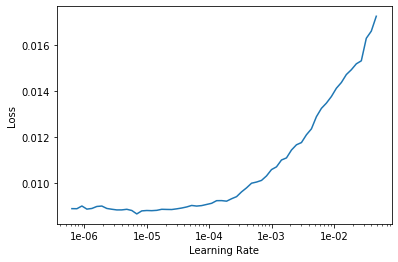

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(7, slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.009274,0.008150,0.090038,07:05
1,0.010072,0.009378,0.096607,07:04
2,0.009084,0.007743,0.087776,07:04
3,0.008201,0.007163,0.084420,07:03
4,0.007780,0.006664,0.081421,06:59
5,0.007499,0.006417,0.079891,07:07
6,0.007652,0.006549,0.080703,07:04


In [0]:
learn.save('Galaxy-big-3')

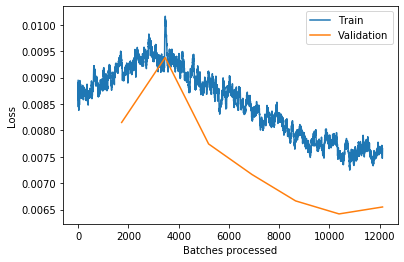

In [0]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


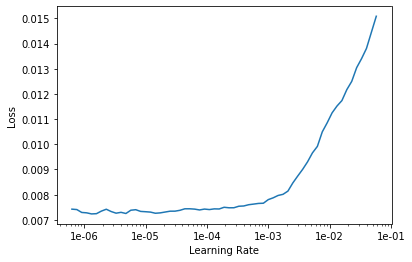

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(7, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007388,0.006433,0.079991,07:02
1,0.007499,0.006476,0.080256,07:02
2,0.007488,0.006363,0.079552,07:08
3,0.007645,0.006335,0.079378,07:08
4,0.007631,0.006378,0.079642,07:06
5,0.007551,0.006349,0.079464,07:02
6,0.007405,0.006352,0.079488,07:08


In [0]:
learn.save('Galaxy-big-4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


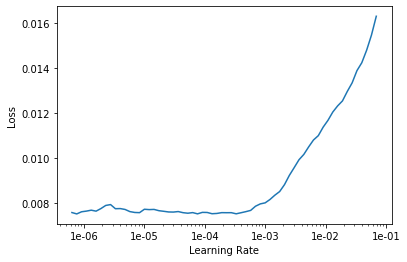

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(7, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007637,0.006350,0.079470,07:06
1,0.007558,0.006554,0.080733,07:07
2,0.007652,0.006525,0.080555,07:05
3,0.007456,0.006380,0.079652,07:05
4,0.007409,0.006334,0.079378,07:03
5,0.007387,0.006229,0.078712,07:07
6,0.007132,0.006214,0.078613,07:08


In [0]:
learn.save('Galaxy-big-4')

In [0]:
learn.load('Galaxy-big-4')

Learner(data=ImageDataBunch;

Train: LabelList (55421 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: FloatList
[0.383147 0.616853 0.       0.       0.616853 0.038452 0.578401 0.418398 0.198455 0.       0.104752 0.512101 0.
 0.054453 0.945547 0.201463 0.181684 0.       0.       0.027227 0.       0.027227 0.       0.       0.       0.
 0.       0.       0.279952 0.138445 0.       0.       0.092886 0.       0.       0.       0.325512],[0.327001 0.663777 0.009222 0.031178 0.632599 0.46737  0.165229 0.591328 0.041271 0.       0.236781 0.160941 0.234877
 0.189149 0.810851 0.       0.135082 0.191919 0.       0.       0.140353 0.       0.048796 0.       0.       0.012414
 0.       0.018764 0.       0.131378 0.45995  0.       0.591328 0.       0.       0.       0.      ],[0.765717 0.177352 0.056931 0.       0.177352 0.       0.177352 0.       0.177352 0.       0.11779  0.059562 0.
 0.       1.       0.       0.741864 0.

In [0]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.007247,0.006201,0.078535,07:03
1,0.007358,0.006248,0.078801,06:53
2,0.007069,0.006398,0.079680,06:53
3,0.007156,0.006232,0.078737,06:55
4,0.007201,0.006898,0.081234,06:49
5,0.007154,0.006234,0.078722,06:51
6,0.007233,0.006184,0.078425,06:55
7,0.006985,0.006156,0.078245,06:54
8,0.007093,0.006228,0.078687,06:57
9,0.007119,0.006188,0.078451,06:53


In [0]:
learn.save('Galaxy-big-5')

##**Testing the model**

In [0]:
! unzip -q -n {path}/images_test_rev1.zip -d {path}

In [0]:
learn.export(path/"export.pkl")

In [0]:
test = ImageList.from_folder(path/'test')
len(test)

79975

**get_preds** by default gives predictions over the validation set, the test set has to be specifically mentioned. 

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

The results have to be put in a certain format for submission, the code for which is written below.

In [0]:
preds = preds.numpy()

In [0]:
fnames = [f.stem for f in learn.data.test_ds.items]

In [0]:
df_t = pd.DataFrame(preds)
df_t.insert(loc=0, column="Galaxy", value=fnames)
df_t.columns = df.columns
df_t.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,561191,0.293375,0.696563,0.010134,0.169861,0.526837,0.114546,0.412413,0.295496,0.231489,...,0.094623,0.101991,0.111715,0.082495,0.010975,0.150052,0.003457,0.002063,0.003051,0.127369
1,613184,0.678935,0.272519,0.048467,0.014958,0.257867,0.011640,0.246609,0.040048,0.218159,...,0.008495,0.028978,0.011463,0.000742,0.005767,-0.006204,-0.000528,0.000787,0.002979,0.040271
2,706446,0.309252,0.681328,0.009603,0.090895,0.590707,0.079568,0.511003,0.239806,0.351238,...,0.027468,0.149645,0.078778,0.011836,0.009106,0.058573,0.005180,0.004279,0.008159,0.156766
3,349870,0.036212,0.959533,0.004767,0.013672,0.945180,0.095438,0.849064,0.908270,0.036545,...,-0.003677,0.522546,0.348702,0.035584,0.048084,0.537219,0.115089,0.033833,0.021681,0.146367
4,951865,0.761752,0.200393,0.038048,0.024542,0.176055,0.009439,0.166890,0.026192,0.149984,...,0.009742,0.015157,0.008063,0.003258,0.004749,0.000816,-0.001143,-0.001302,0.000130,0.024535


In [0]:
df_t.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit galaxy-zoo-the-galaxy-challenge -f {path/'submission.csv'} -m "New enhanced model submission"

###**Result**

Better than 3rd Ranked person

**Private score** - 0.07837 

**Public Score** - 0.07843

##**Improving the Model**

I improve the model by training it for a longer duration with different learning rates.

In [0]:
learn.load('Galaxy-big-5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


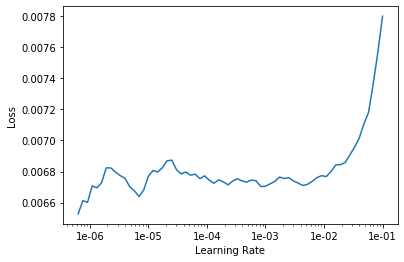

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(7, slice(2e-6, 1e-5))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.006881,0.006287,0.079195,07:02
1,0.006823,0.006255,0.078996,06:46
2,0.006702,0.006208,0.078695,06:46
3,0.006585,0.006177,0.078497,06:50
4,0.006803,0.006172,0.078462,06:44
5,0.006684,0.006180,0.078514,06:49
6,0.006727,0.006198,0.078632,06:49


In [0]:
learn.save('Galaxy-big-6')

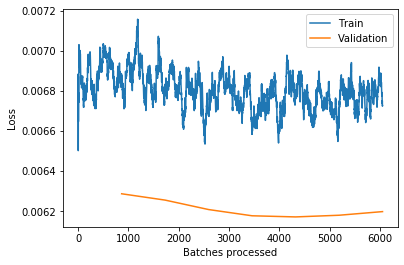

In [0]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


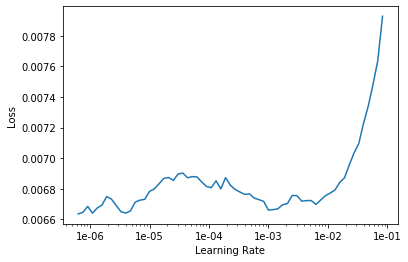

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, slice(5e-5, 1e-3))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.006808,0.006157,0.078371,06:52
1,0.007000,0.006198,0.078629,06:51
2,0.006775,0.006210,0.078702,06:54
3,0.006893,0.006226,0.078814,06:53
4,0.006938,0.006143,0.078275,06:52
5,0.006790,0.006167,0.078437,06:53
6,0.006711,0.006134,0.078227,06:51
7,0.006840,0.006148,0.078318,06:55
8,0.006675,0.006177,0.078503,06:51
9,0.006789,0.006109,0.078060,06:55


In [0]:
learn.save('Galaxy-big-7')

In [0]:
learn.export(path/"export.pkl")

In [0]:
# learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
preds = preds.numpy()

In [0]:
fnames = [f.stem for f in learn.data.test_ds.items]

In [0]:
df_t = pd.DataFrame(preds)
df_t.insert(loc=0, column="Galaxy", value=fnames)
df_t.columns = df.columns
df_t.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,561191,0.285695,0.706116,0.008580,0.159055,0.546557,0.122052,0.424817,0.323211,0.223547,...,0.091443,0.109253,0.121477,0.092821,0.010648,0.167824,0.009207,0.002677,0.004381,0.129535
1,613184,0.681911,0.270672,0.047384,0.008956,0.261775,0.013071,0.248713,0.038024,0.223962,...,0.005448,0.022445,0.011879,0.004186,0.001187,0.001183,-0.001482,0.000157,0.002295,0.035507
2,706446,0.309609,0.682752,0.007955,0.085286,0.597197,0.080932,0.516444,0.234281,0.362977,...,0.026641,0.144512,0.079742,0.009919,0.006131,0.057697,0.007176,0.003269,0.007040,0.152304
3,349870,0.035369,0.958913,0.004830,0.011685,0.947121,0.114033,0.832978,0.919528,0.027327,...,-0.002560,0.527017,0.351559,0.041753,0.046626,0.567072,0.117165,0.030800,0.018835,0.134577
4,951865,0.781265,0.177560,0.041239,0.016799,0.160771,0.008678,0.152051,0.021630,0.139155,...,0.005183,0.007629,0.007961,0.006440,0.002731,0.000323,0.000772,-0.000149,0.000670,0.018271


In [0]:
df_t.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit galaxy-zoo-the-galaxy-challenge -f {path/'submission.csv'} -m "Final Submission"

100%|██████████████████████████████████████| 33.6M/33.6M [00:10<00:00, 3.24MB/s]
Successfully submitted to Galaxy Zoo - The Galaxy Challenge

###**Result**

Close to 2nd Ranked person

**Private score** - 0.07788 

**Public Score** - 0.07794